In [1]:
import pandas as pd
import warnings
warnings.simplefilter("ignore")

log_data = pd.read_csv('/Users/harsha/Desktop/Linux_system_Logs.csv')

In [2]:
log_data.head()

,Month,Date,Timestamp,Hostname,Process,LogMessage
0,Jun,9,06:06:20,combo,syslogd 1.4.1,restart.
1,Jun,9,06:06:20,combo,syslog,syslogd startup succeeded
2,Jun,9,06:06:20,combo,syslog,klogd startup succeeded
3,Jun,9,06:06:20,combo,kernel,"klogd 1.4.1, log source = /proc/kmsg started."
4,Jun,9,06:06:20,combo,kernel,Linux version 2.6.5-1.358 (bhcompile@bugs.buil...


In [3]:
print(log_data.info())
log_data = log_data.drop_duplicates()

log_data = log_data.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27465 entries, 0 to 27464
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       27465 non-null  object
 1   Date        27465 non-null  int64 
 2   Timestamp   27465 non-null  object
 3   Hostname    27465 non-null  object
 4   Process     27465 non-null  object
 5   LogMessage  27465 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.3+ MB
None


In [4]:
def refined_classify_log_type(row):
    process = row['Process'].lower()
    message = row['LogMessage'].lower()
    
    if 'kernel' in process:
        return 'Kernel Log'
    elif 'syslog' in process:
        return 'System Log'
    elif 'sshd' in process or 'pam_unix' in process:
        return 'SSH Log'
    elif 'authentication failure' in message:
        return 'Authentication Failure'
    elif 'out of memory' in message:
        return 'Memory Management Log'
    else:
        # Catch-all for logs that don't fit into known categories
        return 'Specific System Log'

log_data['Log Type'] = log_data.apply(refined_classify_log_type, axis=1)
log_data.head()

,Month,Date,Timestamp,Hostname,Process,LogMessage,Log Type
0,Jun,9,06:06:20,combo,syslogd 1.4.1,restart.,System Log
1,Jun,9,06:06:20,combo,syslog,syslogd startup succeeded,System Log
2,Jun,9,06:06:20,combo,syslog,klogd startup succeeded,System Log
3,Jun,9,06:06:20,combo,kernel,"klogd 1.4.1, log source = /proc/kmsg started.",Kernel Log
4,Jun,9,06:06:20,combo,kernel,Linux version 2.6.5-1.358 (bhcompile@bugs.buil...,Kernel Log


In [5]:
from datetime import datetime

# Check for missing values
missing_values = log_data.isnull().sum()
# Function to convert month name to month number and directly create a datetime object with the year 2022
def month_to_datetime(month_name, day, time):
    # Parse the month name to get a datetime object; initially sets to year 1900
    datetime_object = datetime.strptime(f"{month_name} {day} {time}", "%b %d %H:%M:%S")
    # Replace the year with 2022
    return datetime_object.replace(year=2022)

# Convert 'Month', 'Date', 'Timestamp' into a single datetime column
log_data['DateTime'] = log_data.apply(lambda row: month_to_datetime(row['Month'], row['Date'], row['Timestamp']), axis=1)

# Convert text to lower case for standardization
log_data['Process'] = log_data['Process'].str.lower()
log_data['LogMessage'] = log_data['LogMessage'].str.lower()

# Drop the old date columns as they are now redundant
log_data.drop(['Month', 'Date', 'Timestamp'], axis=1, inplace=True)

log_data.head()

,Hostname,Process,LogMessage,Log Type,DateTime
0,combo,syslogd 1.4.1,restart.,System Log,2022-06-09 06:06:20
1,combo,syslog,syslogd startup succeeded,System Log,2022-06-09 06:06:20
2,combo,syslog,klogd startup succeeded,System Log,2022-06-09 06:06:20
3,combo,kernel,"klogd 1.4.1, log source = /proc/kmsg started.",Kernel Log,2022-06-09 06:06:20
4,combo,kernel,linux version 2.6.5-1.358 (bhcompile@bugs.buil...,Kernel Log,2022-06-09 06:06:20


In [6]:
# Define error-related keywords
error_keywords = ['error', 'fail', 'failure', 'critical', 'exception', 'denied', 'unable', 'warning', 'unexpected']

# Filter log messages containing any of the error keywords
error_logs = log_data[log_data['LogMessage'].str.contains('|'.join(error_keywords), case=False, regex=True)]

# Display the error logs and count occurrences of each type of error
error_logs['ErrorType'] = error_logs['LogMessage'].str.extract('(' + '|'.join(error_keywords) + ')', expand=False).str.lower()

# Display the results: sample error logs and counts of each type of error found
error_logs_sample = error_logs[['DateTime', 'Hostname', 'Process', 'LogMessage', 'Log Type','ErrorType']]
error_type_counts = error_logs['ErrorType'].value_counts()

error_logs_sample.head()

,DateTime,Hostname,Process,LogMessage,Log Type,ErrorType
37,2022-06-09 06:06:20,combo,kernel,there is already a security framework initiali...,Kernel Log,fail
38,2022-06-09 06:06:20,combo,kernel,failure registering capabilities with the kernel,Kernel Log,fail
52,2022-06-09 06:06:21,combo,kernel,enabling unmasked simd fpu exception support.....,Kernel Log,exception
179,2022-06-09 06:06:30,combo,kernel,cdrom: open failed.,Kernel Log,fail
221,2022-06-09 06:06:41,combo,xinetd[2003],bind failed (address already in use (errno = 9...,Specific System Log,fail


In [7]:
error_type_counts

ErrorType
fail          4147
denied         134
warning         19
error           11
exception        8
unexpected       1
unable           1
Name: count, dtype: int64

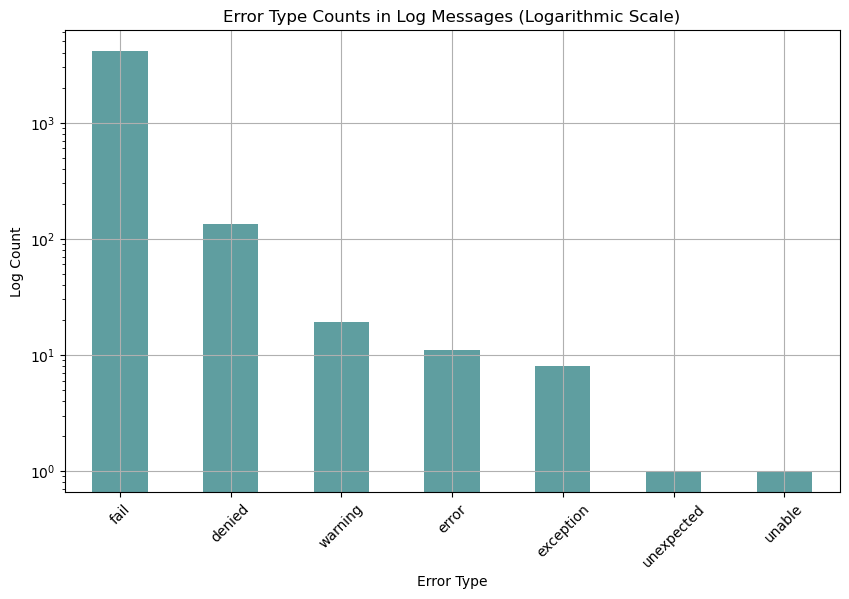

In [8]:
import matplotlib.pyplot as plt

# Plotting with logarithmic scale
plt.figure(figsize=(10, 6))
error_type_counts.plot(kind='bar', color='cadetblue', logy=True)
plt.title('Error Type Counts in Log Messages (Logarithmic Scale)')
plt.xlabel('Error Type')
plt.ylabel('Log Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [9]:
from sklearn.ensemble import IsolationForest
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'log_data' is your DataFrame and 'LogMessage' is the column with log messages
X = log_data['LogMessage']

# Vectorize text data
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

# Initialize the isolation forest model
model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Fit the model
model.fit(X_tfidf)

# Predict anomalies (-1 for outliers, 1 for inliers)
log_data['anomaly'] = model.predict(X_tfidf)

In [10]:
log_data

,Hostname,Process,LogMessage,Log Type,DateTime,anomaly
0,combo,syslogd 1.4.1,restart.,System Log,2022-06-09 06:06:20,1
1,combo,syslog,syslogd startup succeeded,System Log,2022-06-09 06:06:20,1
2,combo,syslog,klogd startup succeeded,System Log,2022-06-09 06:06:20,1
3,combo,kernel,"klogd 1.4.1, log source = /proc/kmsg started.",Kernel Log,2022-06-09 06:06:20,1
4,combo,kernel,linux version 2.6.5-1.358 (bhcompile@bugs.buil...,Kernel Log,2022-06-09 06:06:20,1
...,...,...,...,...,...,...
25460,combo,sshd(pam_unix)[6725],authentication failure; logname= uid=0 euid=0 ...,SSH Log,2022-02-28 01:49:00,1
25461,combo,sshd(pam_unix)[6735],authentication failure; logname= uid=0 euid=0 ...,SSH Log,2022-02-28 01:49:02,1
25462,combo,sshd(pam_unix)[6736],authentication failure; logname= uid=0 euid=0 ...,SSH Log,2022-02-28 01:49:02,1
25463,combo,sshd(pam_unix)[6737],authentication failure; logname= uid=0 euid=0 ...,SSH Log,2022-02-28 01:49:02,1


In [11]:
# Define a function to determine if a log message indicates an anomaly
def label_anomaly(log_message):
    anomaly_keywords = ["Anomaly", "warning", "error", "failure"]
    return any(keyword in log_message for keyword in anomaly_keywords)

# Apply the function to create a new 'Is_Anomaly' column
log_data['Is_Anomaly'] = log_data['LogMessage'].apply(lambda x: 1 if label_anomaly(x) else 0)

log_data.head(50)

,Hostname,Process,LogMessage,Log Type,DateTime,anomaly,Is_Anomaly
0,combo,syslogd 1.4.1,restart.,System Log,2022-06-09 06:06:20,1,0
1,combo,syslog,syslogd startup succeeded,System Log,2022-06-09 06:06:20,1,0
2,combo,syslog,klogd startup succeeded,System Log,2022-06-09 06:06:20,1,0
3,combo,kernel,"klogd 1.4.1, log source = /proc/kmsg started.",Kernel Log,2022-06-09 06:06:20,1,0
4,combo,kernel,linux version 2.6.5-1.358 (bhcompile@bugs.buil...,Kernel Log,2022-06-09 06:06:20,1,0
5,combo,kernel,bios-provided physical ram map:,Kernel Log,2022-06-09 06:06:20,1,0
6,combo,kernel,bios-e820: 0000000000000000 - 00000000000a0000...,Kernel Log,2022-06-09 06:06:20,1,0
7,combo,kernel,bios-e820: 00000000000f0000 - 0000000000100000...,Kernel Log,2022-06-09 06:06:20,1,0
8,combo,kernel,bios-e820: 0000000000100000 - 0000000007eae000...,Kernel Log,2022-06-09 06:06:20,1,0
9,combo,kernel,bios-e820: 0000000007eae000 - 0000000008000000...,Kernel Log,2022-06-09 06:06:20,1,0


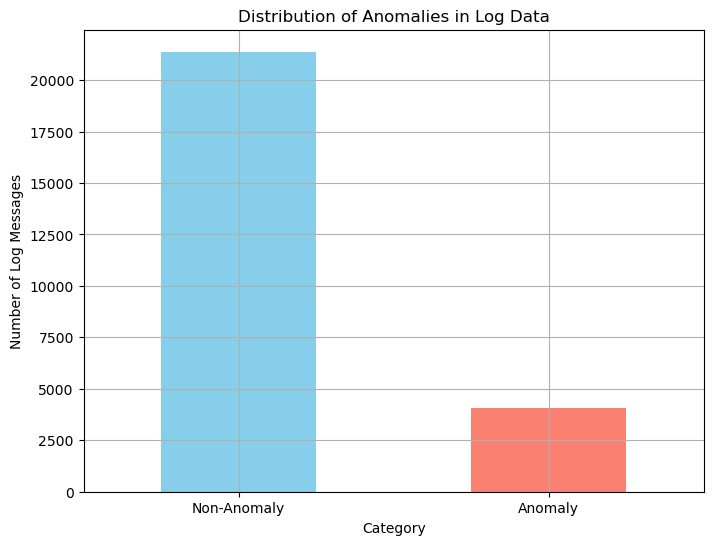

In [12]:
# Count the number of anomaly vs non-anomaly log entries
anomaly_counts = log_data['Is_Anomaly'].value_counts()

# Labels for the plot
labels = ['Non-Anomaly', 'Anomaly']

# Plotting a bar chart for anomaly distribution
plt.figure(figsize=(8, 6))
anomaly_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Anomalies in Log Data')
plt.xlabel('Category')
plt.ylabel('Number of Log Messages')
plt.xticks(ticks=[0, 1], labels=labels, rotation=0)
plt.grid(True)
plt.show()

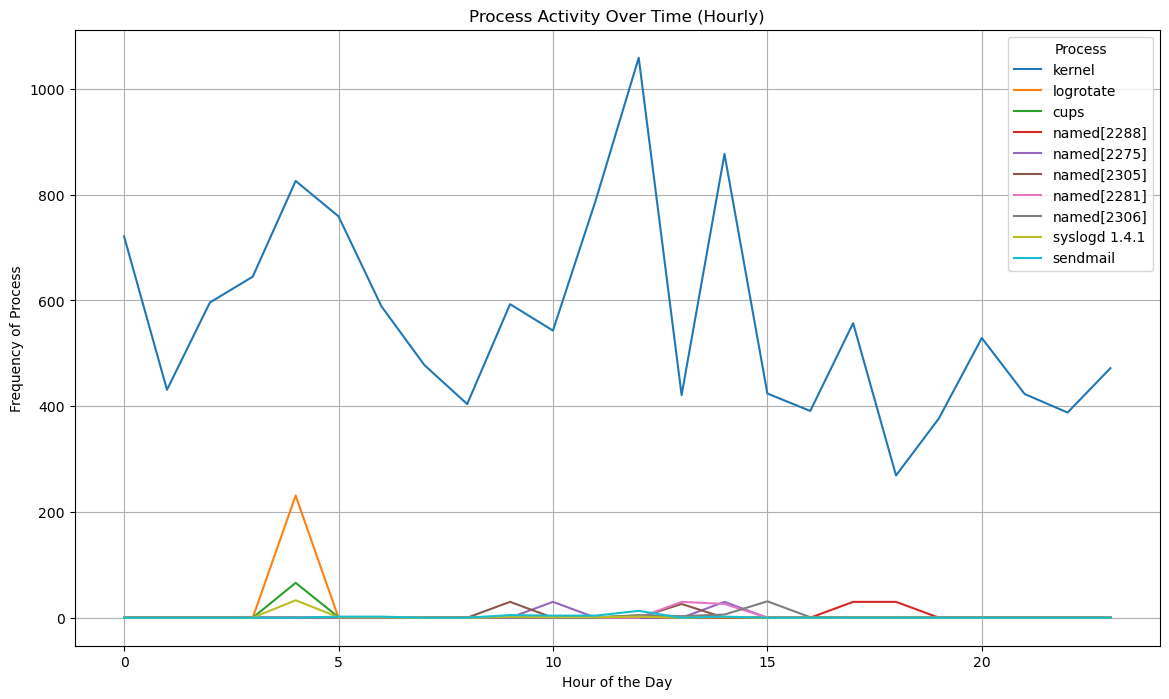

In [13]:
# Assuming 'DateTime' is already converted to a proper datetime type
# Create a new column that represents the hour of each log entry
log_data['Hour'] = log_data['DateTime'].dt.hour

# Group by both 'Process' and 'Hour' and count the occurrences
grouped_data = log_data.groupby(['Process', 'Hour']).size().reset_index(name='Counts')

# Pivot the data for better visualization: rows are hours, columns are processes, values are counts
pivot_data = grouped_data.pivot(index='Hour', columns='Process', values='Counts').fillna(0)

# Select top 10 most frequent processes for a clearer graph
top_processes = log_data['Process'].value_counts().head(10).index
filtered_data = pivot_data[top_processes]

# Plotting
plt.figure(figsize=(14, 8))
for process in top_processes:
    plt.plot(filtered_data.index, filtered_data[process], label=process)

plt.title('Process Activity Over Time (Hourly)')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency of Process')
plt.legend(title='Process')
plt.grid(True)
plt.show()


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Prepare the data: Aggregate common log messages and vectorize them
common_messages = log_data['LogMessage'].value_counts().head(1000).index.tolist()

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Limiting to 1000 features for simplicity
X_common_tfidf = vectorizer.fit_transform(common_messages)

# Use KMeans clustering to identify patterns
n_clusters = 5  # Assuming we want to identify 5 distinct clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_common_tfidf)

# Get cluster assignments for common log messages
clusters = kmeans.labels_

# Display the clustering results
clustered_messages = pd.DataFrame({
    'LogMessage': common_messages,
    'Cluster': clusters
}).sort_values(by='Cluster')

clustered_messages

,LogMessage,Cluster
0,check pass; user unknown,0
587,net: registered protocol family 31,0
590,"device: /dev/hda, found in smartd database.",0
591,"version 3.0.2 (apm bios 1.2, linux driver 1.16ac)",0
592,bluetooth: rfcomm tty layer initialized,0
...,...,...
887,removing device node '/udev/vcs8',4
809,removing device node '/udev/vcsa1',4
37,creating device node '/udev/vcs2',4
38,creating device node '/udev/vcsa2',4


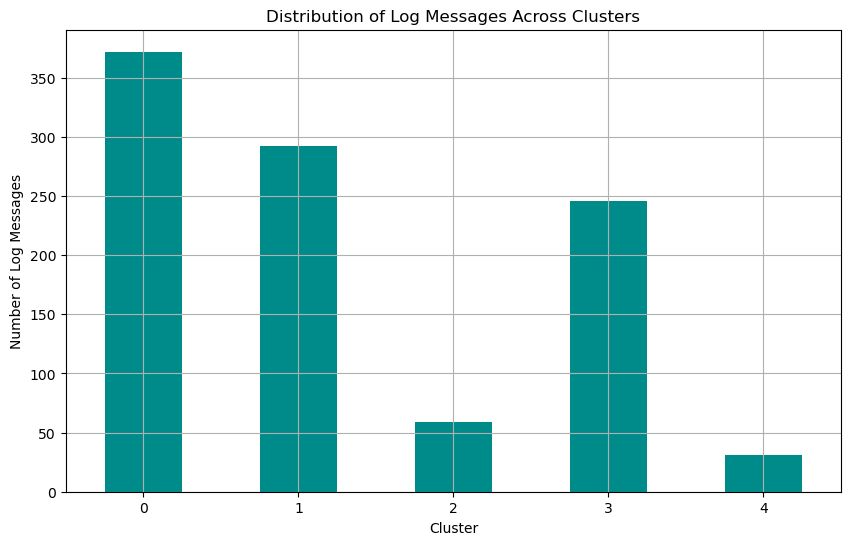

In [17]:
# Count the number of log messages in each cluster
cluster_counts = clustered_messages['Cluster'].value_counts().sort_index()

# Plotting a bar chart for cluster distribution
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='darkcyan')
plt.title('Distribution of Log Messages Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Log Messages')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()
